## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X = np.asarray(X)
            self.y = np.asarray(y)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=40)  
            self.y = y
            
    def predict(self, X):
        if self.algorithm == 'brute':
            X = np.asarray(X)
            dis = sp.cdist(X, self.X, 'euclidean')
            bst_ind = self.get_best_indices(dis)
            vot = np.apply_along_axis(lambda x: np.bincount(x, minlength=4), 1, self.y.take(bst_ind))
            return vot.argmax(axis=1)
        elif self.algorithm == 'kd_tree':
            bst_ind = self.tree.query(X, k=self.n_neighbors, return_distance=False) 
            vot = np.apply_along_axis(lambda x: np.bincount(x, minlength=4), 1, self.y.take(bst_ind))
            return vot.argmax(axis=1)
        
    def get_best_indices(self, ranks: np.ndarray) -> np.ndarray:
        """
        Returns indices of top lowest values in rows of array.

        Parameters
        ----------
        ranks : np.ndarray, required
        Input array.
        top : int, required
            Number of lowest values.
        """
        ind = np.argpartition(ranks, self.n_neighbors, axis=1)[:, :self.n_neighbors] 
        res = np.take_along_axis(ind, np.argsort(np.take_along_axis(ranks, ind, axis=1), axis=1), axis=1)
        return res
    

In [3]:
import scipy.spatial.distance as sp

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 521 µs, sys: 105 µs, total: 626 µs
Wall time: 535 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 16 µs, sys: 1 µs, total: 17 µs
Wall time: 24.1 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 2.45 ms, sys: 423 µs, total: 2.87 ms
Wall time: 2.79 ms


array([1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 972 µs, sys: 764 µs, total: 1.74 ms
Wall time: 1.33 ms


array([1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 960 µs, sys: 264 µs, total: 1.22 ms
Wall time: 1.15 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 183 µs, sys: 7 µs, total: 190 µs
Wall time: 195 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 2.69 ms, sys: 777 µs, total: 3.46 ms
Wall time: 3.08 ms


array([2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 952 µs, sys: 671 µs, total: 1.62 ms
Wall time: 2.09 ms


array([2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
train_data = newsgroups['data']
train_target = newsgroups['target']

len(train_target)

11314

In [26]:
import pandas as pd
df_describe = pd.DataFrame(train_target)
df_describe.describe()

,0
count,11314.000000
mean,9.293000
std,5.562719
min,0.000000
25%,5.000000
50%,9.000000
75%,14.000000
max,19.000000


Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = CountVectorizer(max_df=0.5, min_df=0.01, stop_words='english')
vectorizer2 = TfidfVectorizer(max_df=0.5, min_df=0.01, stop_words='english')

X1 = vectorizer1.fit_transform(train_data)
X2 = vectorizer2.fit_transform(train_data)
y = train_target

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [29]:
from sklearn.model_selection import KFold

In [30]:
kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [35]:
def search_best_res_mink_count(grid):
    scores = [0]*10
    for keys, values in grid.items():
        for value in values:
            for train_index, test_index in kf.split(X1):
                X_train, X_test = X1[train_index], X1[test_index]
                y_train, y_test = y[train_index], y[test_index]
                my_clf = KNeighborsClassifier(n_neighbors=value, algorithm='brute')
                my_clf.fit(X_train, y_train)
                my_clf_pred = my_clf.predict(X_test)
                scores[value - 1] += accuracy_score(y_test, my_clf_pred) / 3
            print("n_neighbors=", value, ' score=', scores[value - 1])
    return scores

In [36]:
def search_best_res_mink_tf(grid):
    scores = [0]*10
    for keys, values in grid.items():
        for value in values:
            for train_index, test_index in kf.split(X2):
                X_train, X_test = X2[train_index], X2[test_index]
                y_train, y_test = y[train_index], y[test_index]
                my_clf = KNeighborsClassifier(n_neighbors=value, algorithm='brute')
                my_clf.fit(X_train, y_train)
                my_clf_pred = my_clf.predict(X_test)
                scores[value - 1] += accuracy_score(y_test, my_clf_pred) / 3
            print("n_neighbors=", value, ' score=', scores[value - 1])
    return scores

In [37]:
def search_best_res_cosine_count(grid):
    scores = [0]*10
    for keys, values in grid.items():
        for value in values:
            for train_index, test_index in kf.split(X1):
                X_train, X_test = X1[train_index], X1[test_index]
                y_train, y_test = y[train_index], y[test_index]
                my_clf = KNeighborsClassifier(n_neighbors=value, algorithm='brute', metric = 'cosine')
                my_clf.fit(X_train, y_train)
                my_clf_pred = my_clf.predict(X_test)
                scores[value - 1] += accuracy_score(y_test, my_clf_pred) / 3
            print("n_neighbors=", value, ' score=', scores[value - 1])
    return scores

In [57]:
def search_best_res_cosine_tf(grid):
    scores = [0]*60
    for keys, values in grid.items():
        for value in values:
            for train_index, test_index in kf.split(X2):
                X_train, X_test = X2[train_index], X2[test_index]
                y_train, y_test = y[train_index], y[test_index]
                my_clf = KNeighborsClassifier(n_neighbors=value, algorithm='brute', metric = 'cosine')
                my_clf.fit(X_train, y_train)
                my_clf_pred = my_clf.predict(X_test)
                scores[value - 1] += accuracy_score(y_test, my_clf_pred) / 3
            print("n_neighbors=", value, ' score=', scores[value - 1])
    return scores

In [39]:
score_mink_count = search_best_res_mink_count({0:[i + 1 for i in range(10)]})

n_neighbors= 1  score= 0.25048633039683793
n_neighbors= 2  score= 0.21981618384202933
n_neighbors= 3  score= 0.22335252502329594
n_neighbors= 4  score= 0.231925419371796
n_neighbors= 5  score= 0.2367861455758205
n_neighbors= 6  score= 0.2376701078414748
n_neighbors= 7  score= 0.2394378214647907
n_neighbors= 8  score= 0.23784666126554732
n_neighbors= 9  score= 0.23634419959432548
n_neighbors= 10  score= 0.23687472693273506


In [40]:
score_mink_tf = search_best_res_mink_tf({0:[i + 1 for i in range(10)]})

n_neighbors= 1  score= 0.19453740800076189
n_neighbors= 2  score= 0.13372846242730355
n_neighbors= 3  score= 0.12435857020878674
n_neighbors= 4  score= 0.14389202485639743
n_neighbors= 5  score= 0.1400030220771925
n_neighbors= 6  score= 0.13425800552841405
n_neighbors= 7  score= 0.1318713003808811
n_neighbors= 8  score= 0.1268334583314703
n_neighbors= 9  score= 0.12400490093932795
n_neighbors= 10  score= 0.12161854730511609


In [49]:
score_cosine_count = search_best_res_cosine_count({0:[1,2,3,4,5,6,7,8,9,10]})

n_neighbors= 1  score= 0.36158713045053037
n_neighbors= 2  score= 0.3408163254784635
n_neighbors= 3  score= 0.3636197679468407
n_neighbors= 4  score= 0.3751095432679622
n_neighbors= 5  score= 0.3889858831312881
n_neighbors= 6  score= 0.3991505469687881
n_neighbors= 7  score= 0.40595640728639304
n_neighbors= 8  score= 0.4137341550683674
n_neighbors= 9  score= 0.41567889080018405
n_neighbors= 10  score= 0.41762381400577175


In [50]:
score_cosine_tf = search_best_res_cosine_tf({0:[i + 1 for i in range(10)]})

n_neighbors= 1  score= 0.39208112196303035
n_neighbors= 2  score= 0.369188770058639
n_neighbors= 3  score= 0.3968531262048119
n_neighbors= 4  score= 0.4152372260293459
n_neighbors= 5  score= 0.4305280320625142
n_neighbors= 6  score= 0.44060430201687095
n_neighbors= 7  score= 0.448117360268065
n_neighbors= 8  score= 0.4502389306346109
n_neighbors= 9  score= 0.4545697387899824
n_neighbors= 10  score= 0.4596074636682862


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

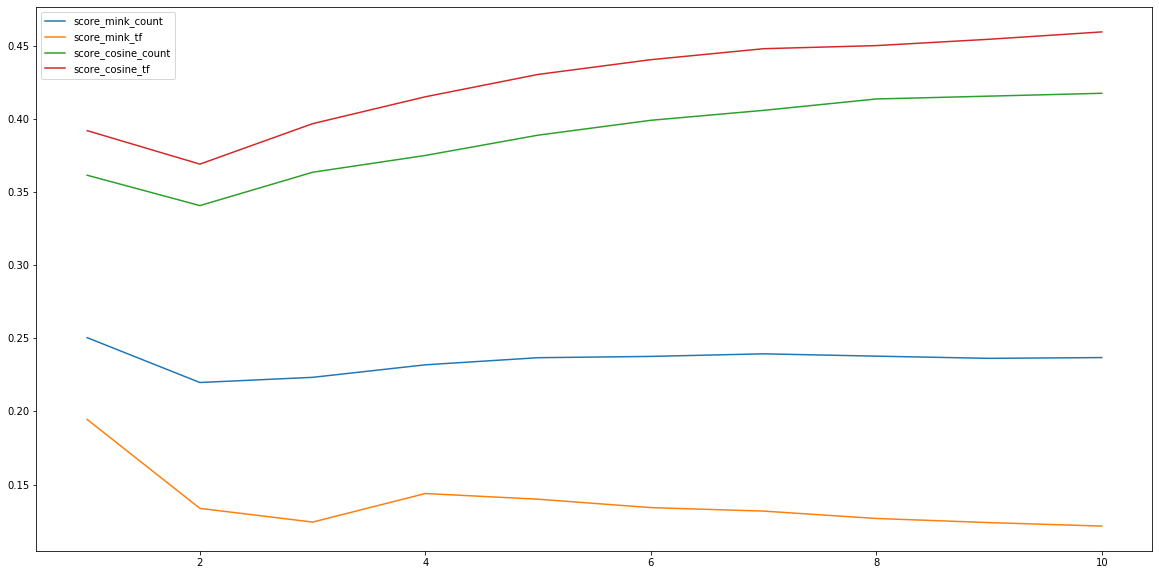

In [53]:
x = [i + 1 for i in range(10)]

fig = plt.figure(figsize= (20,10))

ax1 = fig.add_subplot(111)
ax1.plot(x, score_mink_count, label='score_mink_count') 
ax1.plot(x, score_mink_tf, label='score_mink_tf')
ax1.plot(x, score_cosine_count, label='score_cosine_count')
ax1.plot(x, score_cosine_tf, label='score_cosine_tf')

leg = ax1.legend()

Лучше всего себя ведет КНН с косинусной метрикой и TFIdf векторизацией. Попробуем точнее подобрать оптимальное число соседей. 

In [58]:
score_cosine_tf = search_best_res_cosine_tf({0:[i + 1 for i in range(60)]})

n_neighbors= 1  score= 0.39208112196303035
n_neighbors= 2  score= 0.369188770058639
n_neighbors= 3  score= 0.3968531262048119
n_neighbors= 4  score= 0.4152372260293459
n_neighbors= 5  score= 0.4305280320625142
n_neighbors= 6  score= 0.44060430201687095
n_neighbors= 7  score= 0.448117360268065
n_neighbors= 8  score= 0.4502389306346109
n_neighbors= 9  score= 0.4545697387899824
n_neighbors= 10  score= 0.4596074636682862
n_neighbors= 11  score= 0.4610214377194791
n_neighbors= 12  score= 0.46128654906624467
n_neighbors= 13  score= 0.4654405928895511
n_neighbors= 14  score= 0.469241225219834
n_neighbors= 15  score= 0.4728652338233804
n_neighbors= 16  score= 0.4762240139090541
n_neighbors= 17  score= 0.4763124077921973
n_neighbors= 18  score= 0.4790525244327536
n_neighbors= 19  score= 0.4809082335574488
n_neighbors= 20  score= 0.4824994171909136
n_neighbors= 21  score= 0.48382511453007027
n_neighbors= 22  score= 0.483382863903697
n_neighbors= 23  score= 0.48258762360028573
n_neighbors= 24  sc

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [59]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [60]:
data = newsgroups['data']
target = newsgroups['target']

In [63]:
X_test = vectorizer2.transform(data)
X_test.toarray()
y_test = target
X_train = X2
y_train = y

In [65]:
clf = KNeighborsClassifier(n_neighbors=40, algorithm='brute', metric = 'cosine')
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
print(accuracy_score(y_test, clf_pred))

0.4528677642060542


Точность оказалась ниже точности на кроссвалидации, так как в моделях всегда происходит переобучение.
Возможно это также связано с отсутствующими значениями в словарях. 